In [2]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
file_contents = open("pilatus800.jpg").read() 

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2019-03-23 17:42:24--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  45.4MB/s    in 1.0s    

2019-03-23 17:42:26 (45.4 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
--2019-03-23 17:42:29--  https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
Resolving github.com (github.com)... 140.82.118.4, 140.82.118.3
Connecting to github.com (github.com)|140.82.118.4|:443... connec

Instructions for updating:
Colocations handled automatically by placer.


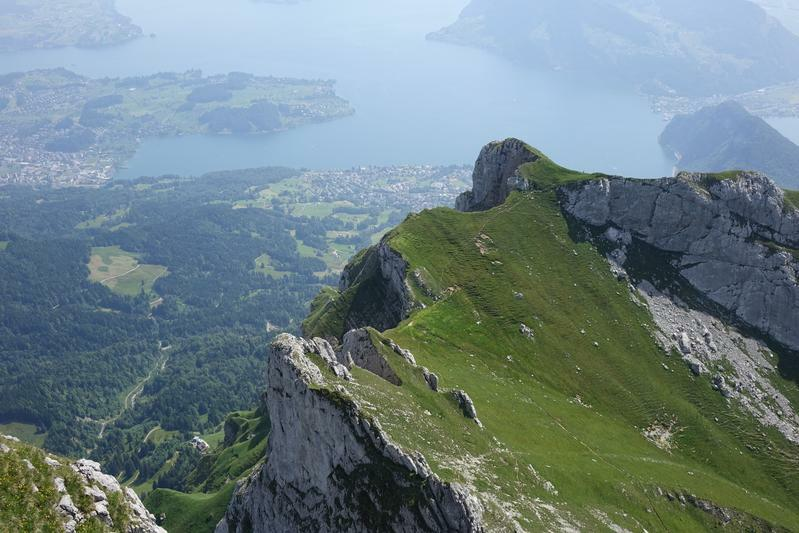

In [3]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### 4) The core deepdream code

In [0]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### 4) Let's deep dream !

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

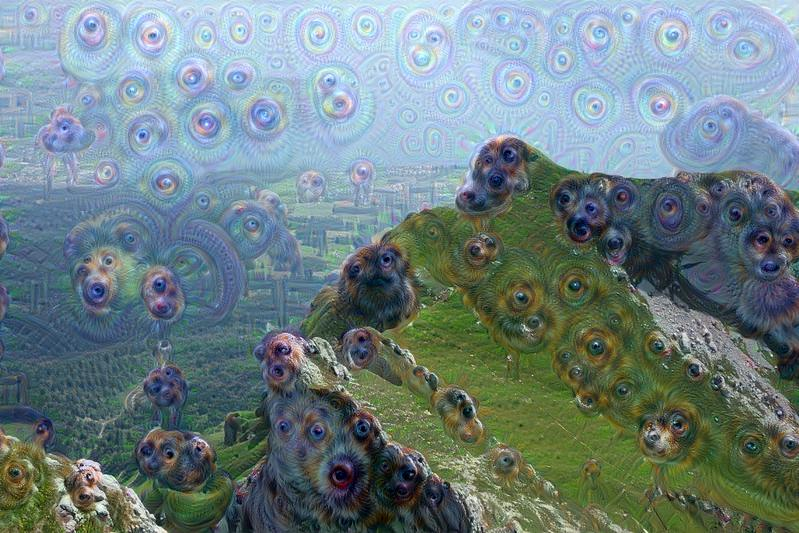

In [9]:
octave_n = 3 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 19 #@param {type:"slider", max: 50}
strength = 175 #@param {type:"slider", max: 1000}
layer = "mixed4a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)


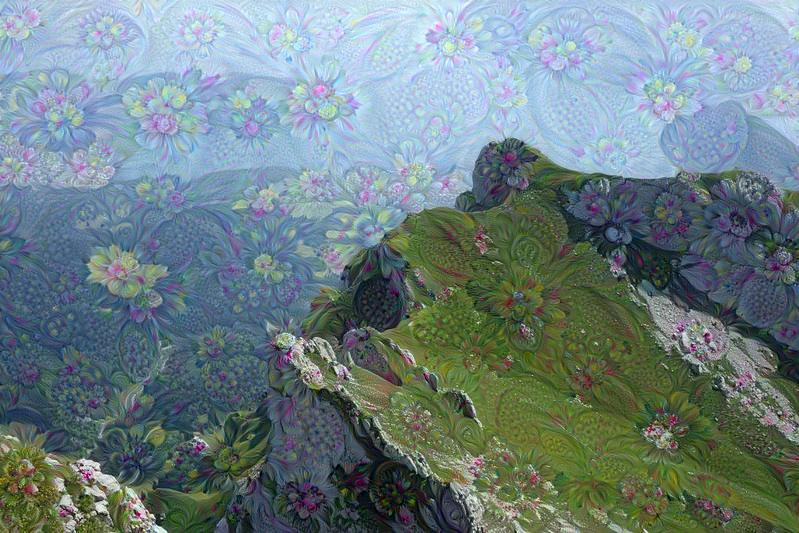

In [10]:
feature_channel = 139 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)

### 6) Zooming iterative DeepDream

We can enter completely immersive worlds by iteratively sooming into the picture:

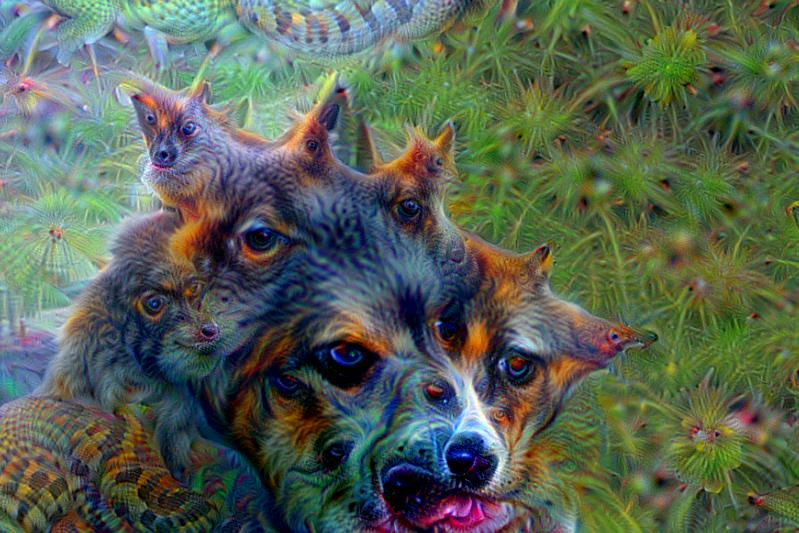

In [11]:
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 5 #@param {type:"slider", max: 50}
strength = 150 #@param {type:"slider", max: 1000}
zooming_steps = 20 #@param {type:"slider", max: 512}
zoom_factor = 1.1 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

We can also use TensorBoard to visualize the full graph to understand bettter how these different layers relate to each other. Most of the code in the next section just makes the graph look a little bit cleaner.